# Getting information from your time series data


You gathered your data. What is next? Probably, it is time to do some "information harvesting". Let's check out some methods that will help to see what's in the data.

In [2]:
#some standard libraries
import numpy as np
import math
import matplotlib.pyplot as plt
#library for power-law red-noise generation
import colorednoise as cn

Generate the time-series with underlying sine wave with white-noise background.

Text(0, 0.5, 'Signal')

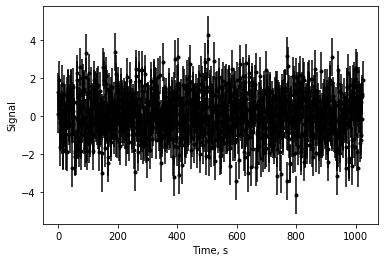

In [3]:
#generate the signal

N=1024 #number of elements in the list
f0=1/10. #frequency of periodic signal
A=1. #amplitude
phi0=np.random.uniform(0,1) # random phase

time_list=np.arange(0, N, 1)
signal=A*np.sin(2*math.pi*f0*time_list+phi0) #generating the signal here
noise=np.random.normal(0.,1, N) #white Gaussian noise
err=[1. for i in range(N)]
sig_obs=signal+noise #combine signal and noise
plt.errorbar(time_list, sig_obs, err, c="black", fmt=".")
plt.xlabel("Time, s")
plt.ylabel("Signal")

## DFT



Perhaps, the simplest and most boadly used way of revealing the periodiciites is the Fourier transform. Since 1807.

DFT creates a beautiful peak from a sine wave function in abs(FFT(signal))**2 vs freq domain.

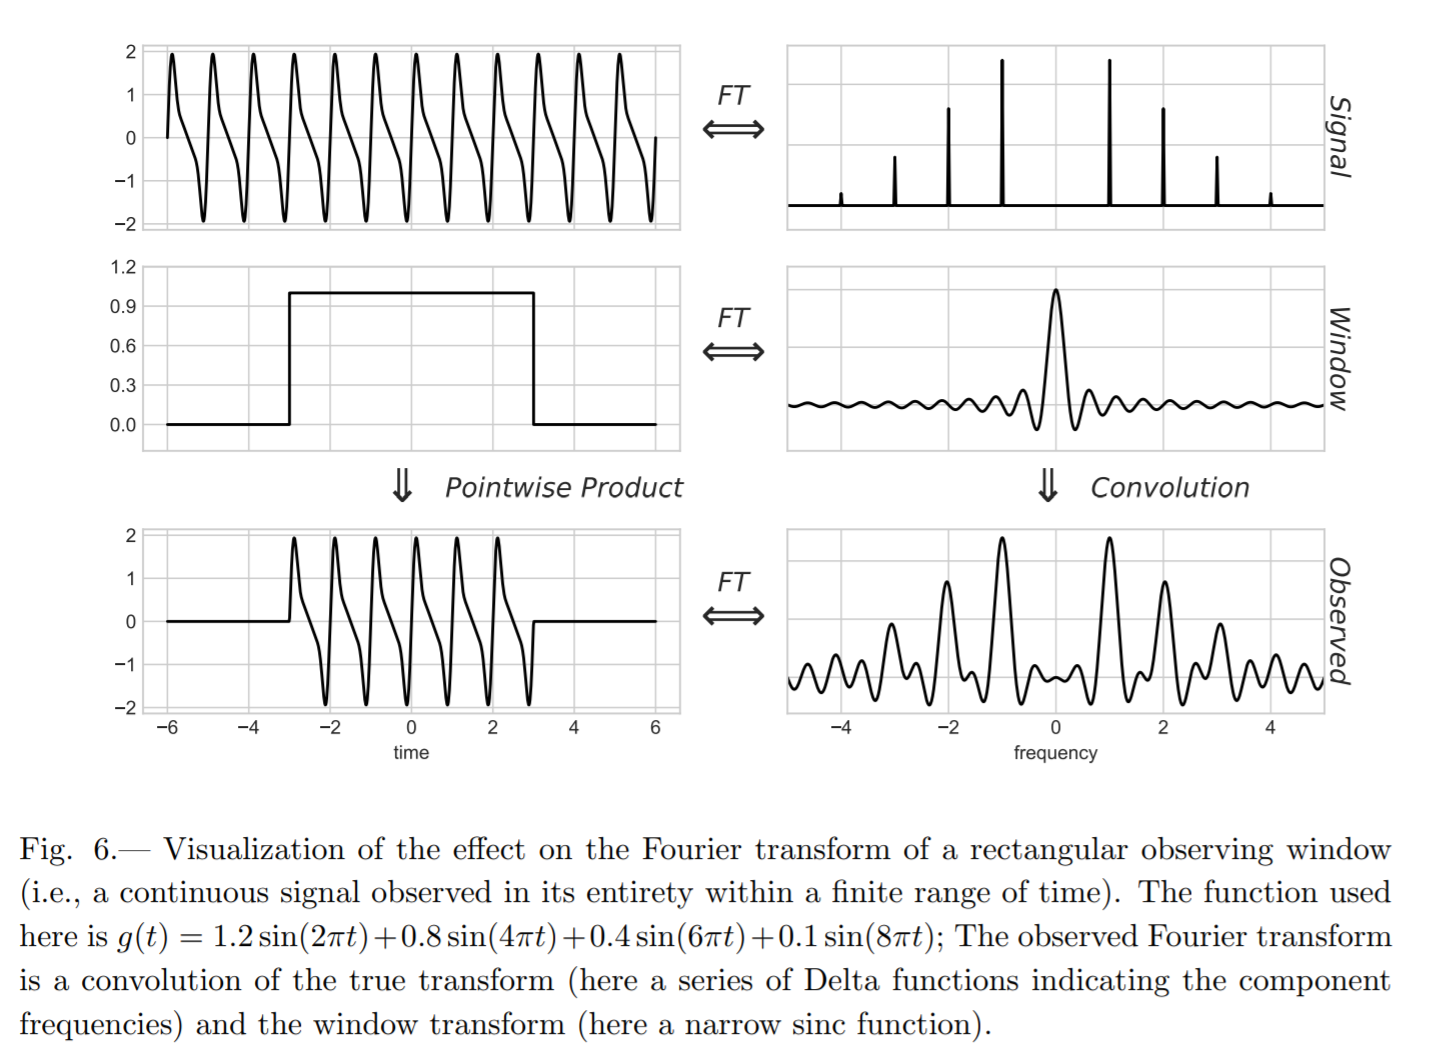

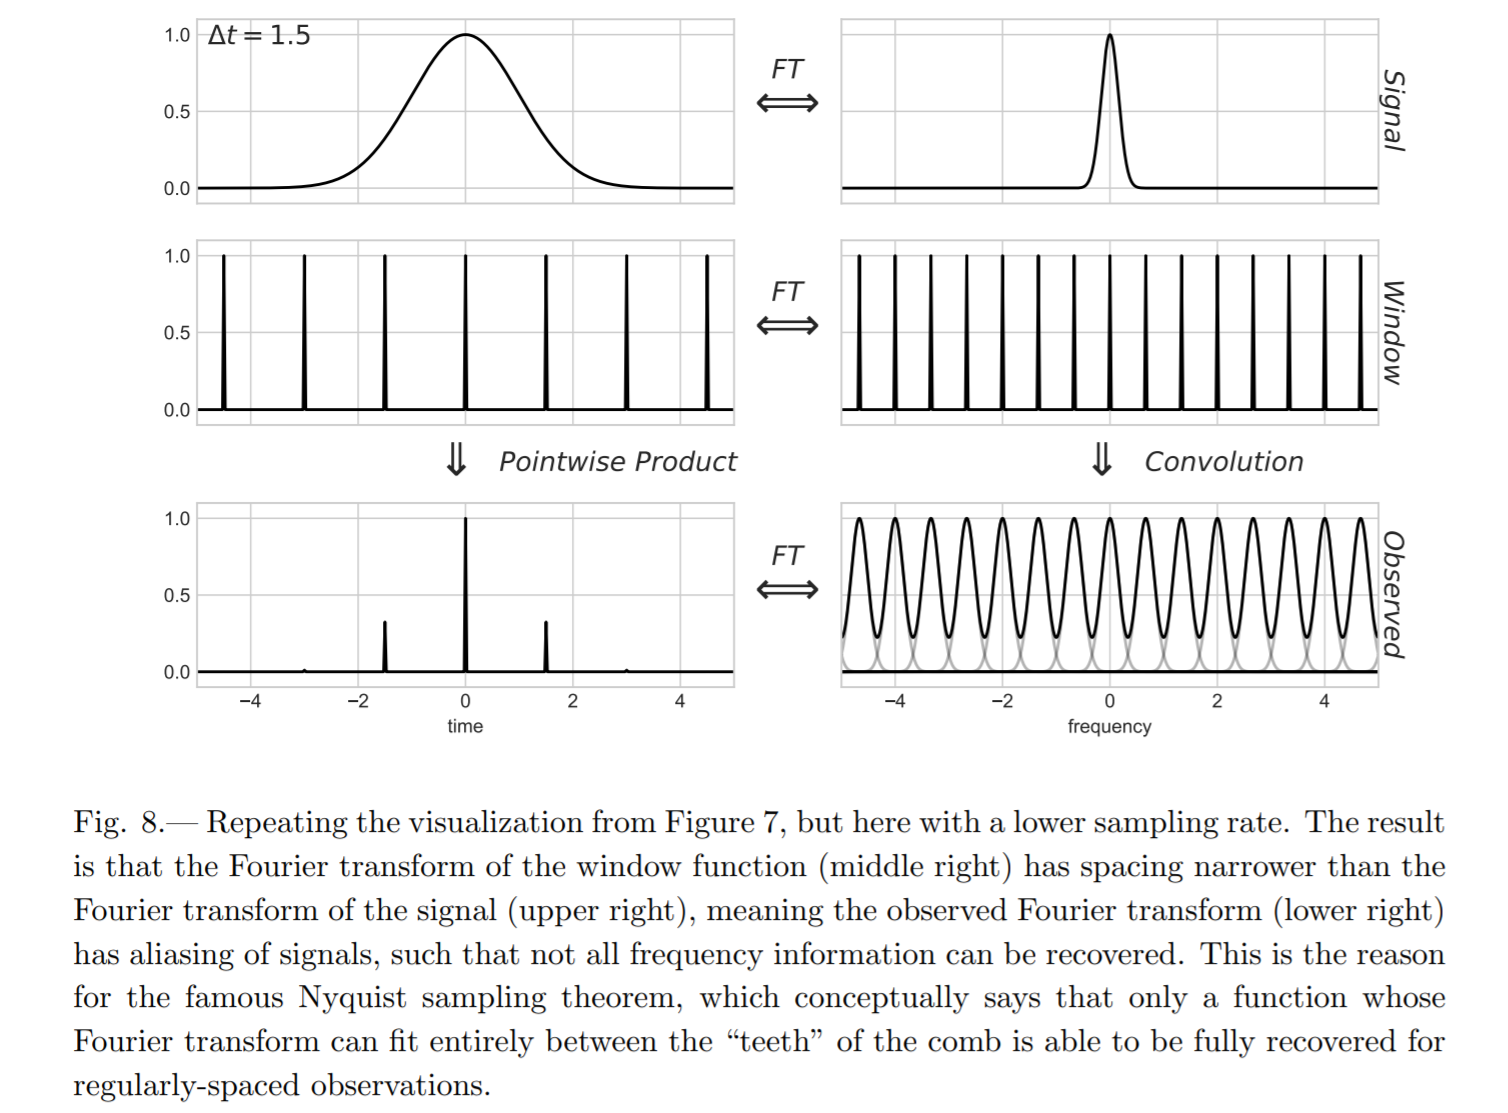

Text(0, 0.5, 'Power')

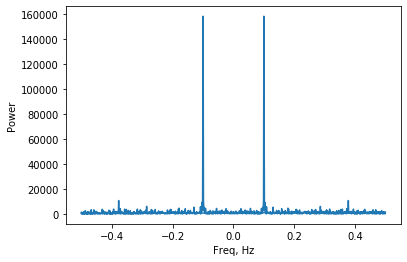

In [7]:
#DFT from numpy
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[0:N], power_FT[0:N])
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
#plt.xscale("log")
#plt.yscale("log")

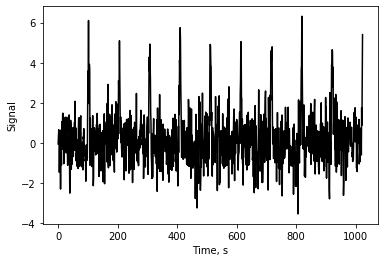

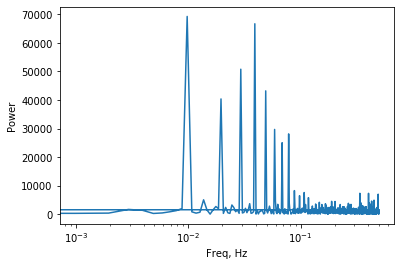

In [9]:


#function, which calculates sequence of Gaussians
def gausspulse(t, num, sigma):
    signal=np.zeros(len(t))
    time_steps=[len(t)/num*(i+1) for i in range(num)]
    for i in range(len(time_steps)):
        signal+=np.exp(-sigma*(t-time_steps[i])**2)
    return signal

#generate the signal
N=1024 #number of elements in the list
f0=1/100. #frequency of periodic signal
A=5. #amplitude
phi0=np.random.uniform(0,1) # random phase

time_list=np.arange(0, N, 1)
signal=A*gausspulse(time_list, int(N*f0), 0.1)
err=[1. for i in range(N)]
noise=np.random.normal(0.,1, N) #white Gaussian noise
sig_obs=signal+noise
plt.plot(time_list, sig_obs, c="black")
plt.xlabel("Time, s")
plt.ylabel("Signal")
plt.show()
#DFT
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[0:N], power_FT[0:N])
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
plt.xscale("log")
#plt.yscale("log")
plt.show()

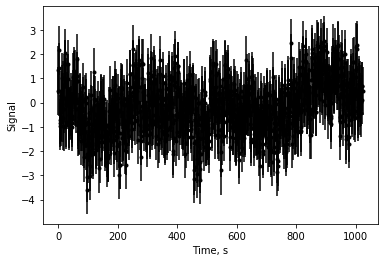

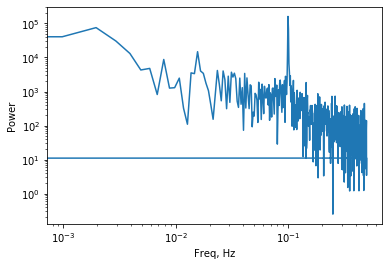

In [11]:
#generate the sine wave signal with the background correlated noise

N=1024 #number of elements in the list
f0=1/10. #frequency of periodic signal
A=1. #amplitude
phi0=np.random.uniform(0,1) # random phase

#slope of the power-law red noise in frequency domain
a=1.2

phi0=np.random.uniform(0,1)
time_list=np.arange(0, N, 1)
signal=A*np.sin(2*math.pi*f0*time_list+phi0)
color_noise=cn.powerlaw_psd_gaussian(a, N) #generating the colored noise here
err=[1. for i in range(N)]
sig_obs=signal+color_noise
plt.errorbar(time_list, sig_obs, err, c="black", fmt=".")
plt.xlabel("Time, s")
plt.ylabel("Signal")
plt.show()
#DFT
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[0:N], power_FT[0:N])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
plt.show()


## Lomb-Scargle Periodogramm

In the real world, particularly in fields like Astronomy where observations are subject to influences of weather and diurnal, lunar, or seasonal cycles, the sampling rate is generally far from uniform.

The Lomb-Scargle periodogram is a well-known algorithm to search for periodicities in irregularly sampled data. The Lomb-Scargle periodogram (generalised, significance of a peak, floating means etc, please see https://arxiv.org/pdf/1703.09824.pdf)

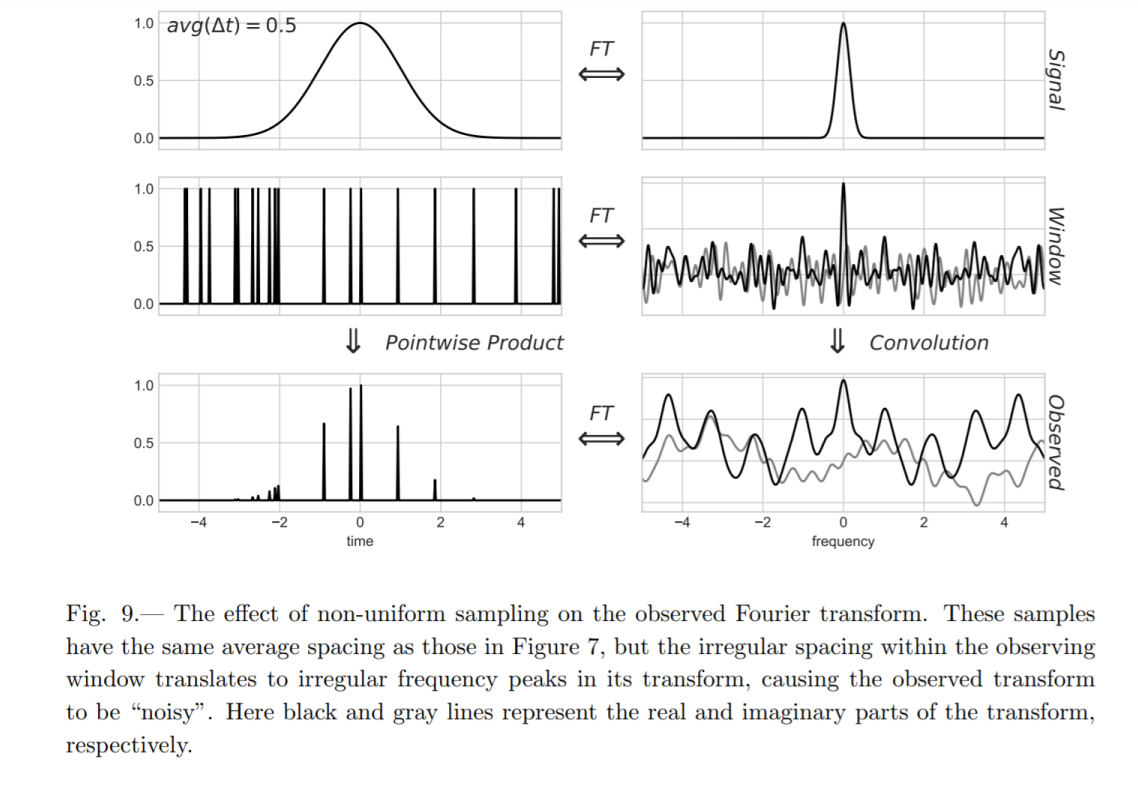


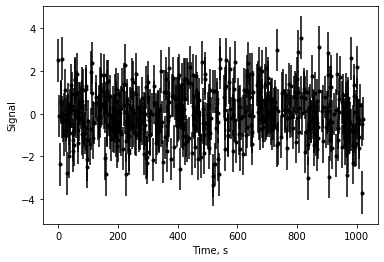

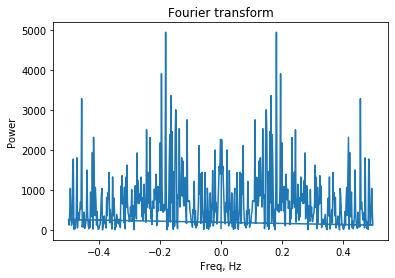

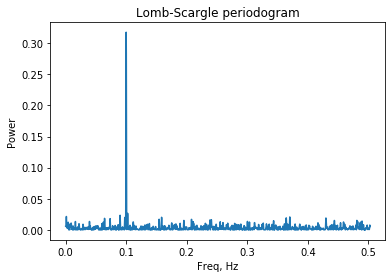

In [13]:
#signal parameters
N=1024 #number of elements in the list
f0=1/10. #frequency of periodic signal
A=1. #amplitude
phi0=np.random.uniform(0,1) # random phase

time_list_masked=time_list
#masking the data
for i in range(int(0.5*N)):
    time_list_masked=np.delete(time_list_masked, np.random.randint(0,len(time_list_masked)))

signal=A*np.sin(2*math.pi*f0*time_list_masked+phi0)
noise=np.random.normal(0.,1, len(signal))
err=[1. for i in range(len(signal))]
sig_obs=signal+noise

plt.errorbar(time_list_masked, sig_obs, err, c="black", fmt=".")
plt.xlabel("Time, s")
plt.ylabel("Signal")
plt.show()

#DFT
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[0:len(time_list_masked)], power_FT[0:len(time_list_masked)])
plt.title("Fourier transform")
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
plt.show()

#Lomb-Scargle for unevenly sampled data from astropy
from astropy.stats import LombScargle
#can be easily generalised
frequency, power = LombScargle(time_list_masked, sig_obs).autopower(nyquist_factor=2)
plt.plot(frequency, power)
plt.title("Lomb-Scargle periodogram")
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
plt.show()
#plt.xscale("log")
#plt.yscale("log")


## Wavelets

In Fourier transform, the signal is decomposed into the sum of sines and cosines. In contrast, within wavelet analysis the signal is decomposed into wavelets, functions which limited in time and frequncy. Therefore, the time resolution is better thn for the Fourier transform. The wavelet transform projects a signal into time vs scale domain. The scale of the wavelet can be associated with the frequency.

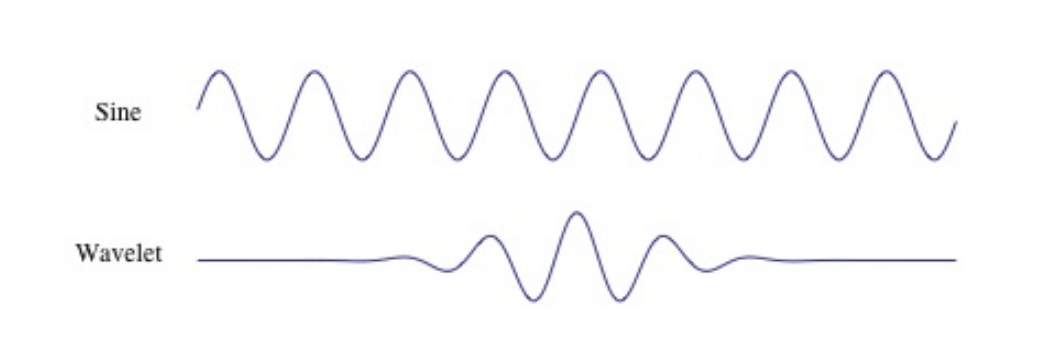


In [17]:
import pywt #open source wavelet transform software in python
import scaleogram as scg #user friendly tool for pywt
from astroML.fourier import wavelet_PSD #astroML also has wavelet transform library (only Gaussian wavelets)
import scipy.signal

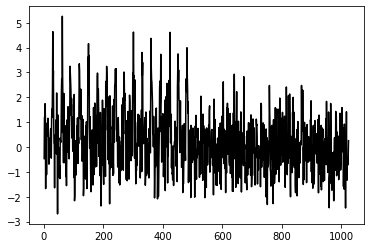

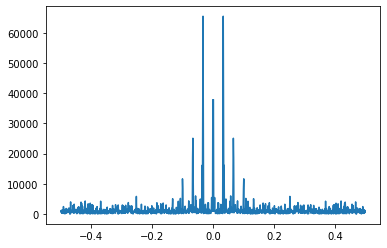

In [18]:
#generate the signal
N=1024 #number of elements in the list
f0=1/30. #frequency of periodic signal
A=1.5 #amplitude
phi0=np.random.uniform(0,1) # random phase

time_list=np.arange(1, N+1, 1)
window=scipy.signal.square(1/200.*time_list, duty=0.4)+1.
signal=A*gausspulse(time_list, int(N*f0), 0.1)
noise=np.random.normal(0.,1.0, N)
err=[1. for i in range(N)]
sig_obs=window*signal+noise #signal is not persistent, e.g. nulling pulses
plt.plot(time_list, sig_obs, c="black")
plt.show()
#DFT
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[1:len(time_list)], power_FT[1:len(time_list)])
plt.show()

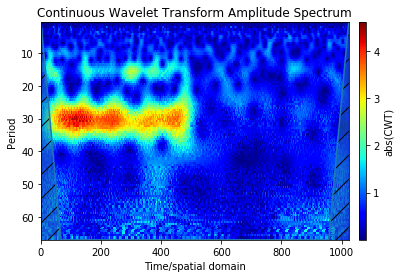

In [19]:
#scg.set_default_wavelet('haar')
#[coef, freq] = pywt.cwt(sig_obs, np.arange(1, N),'haar')
scg.cws(sig_obs, scales=np.arange(1, 100), wavelet='cmor1-1.5')

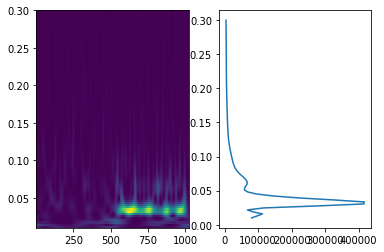

In [20]:
#astroML library also supports wavelets
freq = np.linspace(0.01, 0.3, 100)
wPSD = wavelet_PSD(time_list, sig_obs, freq, Q=1.0)
plt.subplot(121)
plt.imshow(wPSD, origin='lower', aspect='auto',
          extent=[time_list[0], time_list[-1], freq[0], freq[-1]])
plt.subplot(122)
plt.plot(wPSD.sum(axis=1), freq)


## Singular spectrum analysis

Non-parametric time series analysis.SVD-based decomposition of a time series. The basis functions are sines and cosines, but the eigentriple of the SVD decomposition.


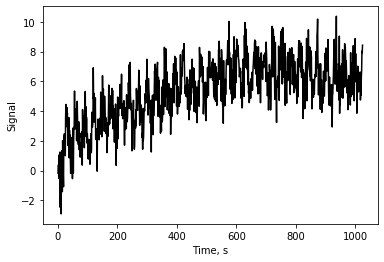

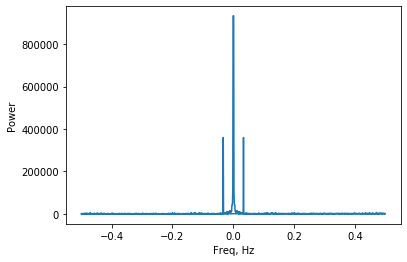

In [22]:
import scipy.signal
#generate the signal
N=1024 #number of elements in the list
f0=1/30. #frequency of periodic signal
A=3. #amplitude
phi0=np.random.uniform(0,1) # random phase
a_t=5. #amplitude of the long-term trend
f_t=1/3000.

time_list=np.arange(1, N+1, 1)
#signal=A*scipy.signal.square(2*math.pi*f0*time_list, duty=0.1)
signal=A*gausspulse(time_list, int(N*f0), 0.01)
noise=np.random.normal(0.,1, N)
trend=a_t*np.sin(2*math.pi*f_t*time_list)
err=[1. for i in range(N)]
sig_obs=signal+trend+noise
plt.plot(time_list, sig_obs, c="black")
plt.xlabel("Time, s")
plt.ylabel("Signal")
plt.show()
#DFT
power_FT=abs(np.fft.fft(sig_obs))**2
freq_FT=np.fft.fftfreq(len(sig_obs), 1.)
plt.plot(freq_FT[1:len(time_list)], power_FT[1:len(time_list)])
plt.xlabel("Freq, Hz")
plt.ylabel("Power")
#plt.xscale("log")
plt.show()


## Modelling your data. Parametric data analysis.

Modelling the data within Bayesian and frequentist inferences.

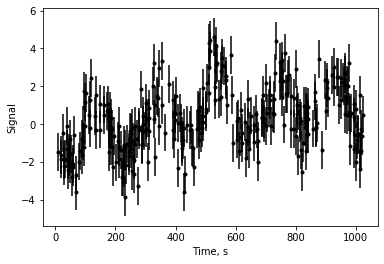

In [28]:
#generate the signal (simple sine wave)
N=1024
f0=10**(-2.3)
A=1.5
phi0=3.4
a=1.8

#data is irregularly sampled
time_list=np.arange(0, N, 1)
time_list_masked=time_list
for i in range(int(0.7*N)):
    time_list_masked=np.delete(time_list_masked, np.random.randint(0,len(time_list_masked)))
signal=A*np.sin(2*math.pi*f0*time_list_masked+phi0)
#uncertainties
err=np.array([1. for i in range(len(time_list_masked))])

#adding noise to the data
color_noise=0.7*cn.powerlaw_psd_gaussian(a, len(time_list_masked))
w_noise=np.random.normal(0.,1, len(time_list_masked))

sig_obs=signal+w_noise+color_noise

plt.errorbar(time_list_masked, sig_obs, err, c="black", fmt=".")
plt.xlabel("Time, s")
plt.ylabel("Signal")
plt.show()

In [29]:
#defining the likelihood and priors for parameters. 
#Used in both Bayesian and frequentist inferences
def log_likelihood(theta, x, y, yerr):
    A1, logf1, phi1 = theta
    model = A1*np.sin(2*math.pi*10**logf1*x+phi1)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def prior(cube, ndim, nparams):
    cube[0]=10.*cube[0]
    cube[1]=5*cube[1]-3.
    cube[2]=np.mod(2*math.pi*cube[2], 2*math.pi)
def loglike_mnest(cube, ndim, nparams):
    theta=cube[0], cube[1], cube[2]
    return log_likelihood(theta, time_list_masked, sig_obs, err)

In [30]:
##  Frequentist analysis=maximization of the likelihood
# ------------------------------------------------------
from scipy.optimize import differential_evolution
from scipy.optimize import least_squares
import pandas as pd

res = lambda *args: -log_likelihood(*args)

#limited priors
bounds = [(0., 10.), (-3., 3.),(0, 2*math.pi)]

#maximization with stochastic population based method 
least_sq_stoch = differential_evolution(res, bounds, args=(time_list_masked, sig_obs, err), maxiter=3000)
A_ml, logf0_ml, phi_ml = least_sq_stoch.x

#least_sq_sln=least_squares(res, least_sq_stoch.x, args=(time_list_masked, sig_obs, err))
#A_ml, logf0_ml, phi_ml = least_sq_sln.x
#jacm=least_sq_sln.jac
#hess=np.dot(np.transpose(jacm), jacm)
#cov=np.linalg.inv(hess)
#errm=cov*errfunc(least_sq_sln.x, time_list_masked, sig_obs, err)
#print hess

items = [[A, A_ml], [f0, 10**logf0_ml], [phi0, phi_ml]]
df = pd.DataFrame(items, columns=['Injected', 'Found'], dtype=float)
df

,Injected,Found
0,1.500000,1.551381
1,0.005012,0.004973
2,3.400000,3.476586


In [ ]:
import pymultinest
parameters = ["A", "logf0", "phi0"]
nparams=len(parameters)
#running the sampler
pymultinest.run(loglike_mnest, prior, nparams, n_live_points=400, verbose=True, resume=False, outputfiles_basename="chains/ex_")

In [ ]:
#show the results on corner plot
from pymultinest.analyse import Analyzer
import corner
a = Analyzer(nparams, outputfiles_basename = "chains/ex_")
stats = a.get_stats()

# get the best fit (highest likelihood) point
bestfit_params = a.get_best_fit()

data = a.get_data()[:,2:]
weights = a.get_data()[:,0]

mask = weights > 1e-5

corner.corner(data[mask,:], weights=weights[mask], labels=parameters, truths=[A, np.log10(f0), phi0], show_titles=True, title_fmt='.3f')


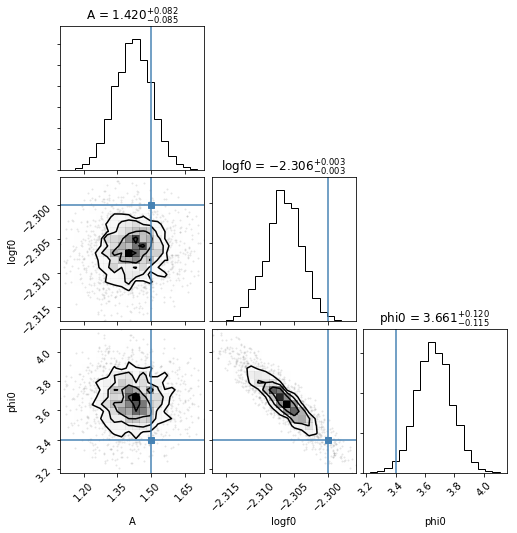